# One-way ANalysis Of VAriance (ANOVA)
ANalaysis Of VAriance (ANOVA) is often colloquially described as extension of the Student's *t*-test, in which only two groups (A and B) are compared. If we have three or more groups, we can compare their within-group variances to their between-group variance, which will provide as an F-statistic. "One-way" in the method name means that our study is univariate - i.e., the dependent variable is affected by only one factor (e.g., differences in the average number of cigarettes burned per day between provinces in Poland). Keep in mind that this is a parametric test, which means that certain conditions about the form of the variables must be met. 

## One-way ANOVA

In [11]:
check.normal <- function(Y, X){
    k <- levels(X)
    for(g in k){
        p.val <- shapiro.test(Y[X == g])$p.value
        if(p.val < 0.05){
            cat(sprintf('Brak normalności rozkładu czynnika ilościowego w grupie %s.\n', g))
            }
    }
}

check.var <- function(Y, X){
    p.val <- bartlett.test(Y, g = X)$p.value
    if(p.val < 0.05){
        print('The variances between groups are not homogeneous.\n')
    }
}

LSD_test <- function(n, k.len, MSe, n.grps, M.grps){
    LSD.vals <- c()
    for(k.i in seq(1, nrow(n.grps)-1)){
        for(k.j in seq(k.i+1, nrow(n.grps))){
            LSD <- qt(0.975, n-k.len) * sqrt(MSe * (1/n.grps[k.i, 2] + 1/n.grps[k.j, 2]))
            if(abs(M.grps[k.i, 2] - M.grps[k.j, 2]) > LSD){
                LSD.vals <- c(LSD.vals, as.character(paste(k.i, k.j, sep = "-")))
            }
        }
    }
    return(LSD.vals)
}

In [12]:
one.way <- function(Y, X1){
    k <- levels(X1)
    k.len <- length(k)
    
    stopifnot(k.len > 2)
    check.normal(Y, X1)
    check.var(Y, X1)
    
    Y <- as.matrix(Y)
    X1 <- as.matrix(X1)
    
    n <- nrow(Y)
    intercept <- matrix(1, nrow(Y), 1)
    Z <- matrix(0, n, k.len-1)
    
    for(i in 1:n){
        idx <- match(X1[i], k[-1])
        Z[i, idx] <- 1
    }
    X <- cbind(intercept, Z)
    
    A <- crossprod(X, Y)
    B <- solve(crossprod(X))
    b <- B %*% A
    M.gen <- mean(Y)
    
    SSR <- crossprod(b, A) - n * M.gen^2
    SSE <- crossprod(Y) - crossprod(b, A)
    
    df.R <- k.len-1
    df.E <- n - k.len
    
    MSR <- SSR/df.R
    MSE <- SSE/df.E
    
    F <- MSR/MSE
    p.value <- pf(F, df.R, df.E, lower.tail = FALSE)
    
    LSD.result <- NA
    if(p.value < 0.05){
        n.grps <- aggregate(Y ~ X1, FUN = length)
        M.grps <- aggregate(Y ~ X1, FUN = mean)
        LSD.result <- LSD_test(n, k.len, MSE, n.grps, M.grps)
    }
    
    SS <- rbind(SSR, SSE)
    df <- rbind(df.R, df.E)
    MS <- rbind(MSR, MSE)
    
    return(list(summary = data.frame(Df = df,
               SS = SS,
               MS = MS,
               F = F,
               p.value = p.value,
               row.names = c('X', 'Residuals')),
                LSD.test = LSD.result))
}

## Case: ToothGrowth dataset

In [13]:
library(ggplot2)

In [14]:
str(ToothGrowth)

'data.frame':	60 obs. of  3 variables:
 $ len : num  4.2 11.5 7.3 5.8 6.4 10 11.2 11.2 5.2 7 ...
 $ supp: Factor w/ 2 levels "OJ","VC": 2 2 2 2 2 2 2 2 2 2 ...
 $ dose: Factor w/ 3 levels "0.5","1","2": 1 1 1 1 1 1 1 1 1 1 ...


In [15]:
ToothGrowth$dose <- as.factor(ToothGrowth$dose)

summary(ToothGrowth)

      len        supp     dose   
 Min.   : 4.20   OJ:30   0.5:20  
 1st Qu.:13.07   VC:30   1  :20  
 Median :19.25           2  :20  
 Mean   :18.81                   
 3rd Qu.:25.27                   
 Max.   :33.90                   

In [16]:
aggregate(len ~ dose,
          data = ToothGrowth,
          FUN = function(x) {y <- shapiro.test(x); c(y$p.value)})

dose,len
<fct>,<dbl>
0.5,0.2466015
1,0.1638821
2,0.9019115


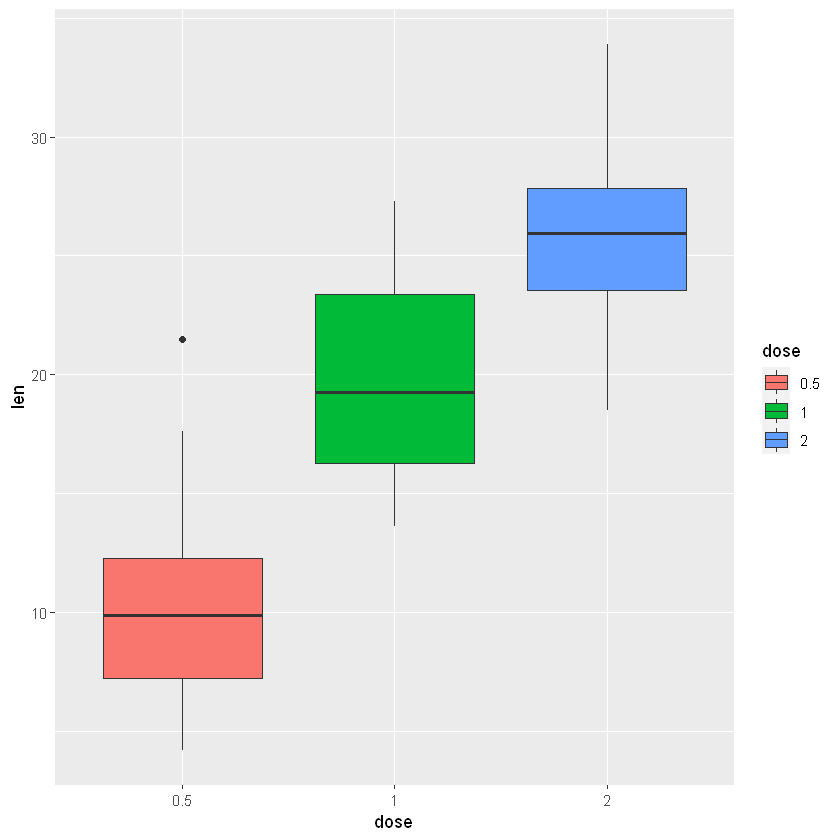

In [17]:
ggplot(ToothGrowth, aes(x = dose, y = len)) +
    geom_boxplot(aes(fill = dose))

In [19]:
aov_model_mine <- one.way(Y = ToothGrowth$len, X1 = ToothGrowth$dose)
aov_model_R <- aov(len ~ dose, data = ToothGrowth)

aov_model_mine
summary(aov_model_R)
TukeyHSD(aov_model_R)

,Df,SS,MS,F,p.value
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X,2,2426.434,1213.21717,67.41574,9.532727e-16
Residuals,57,1025.775,17.99605,67.41574,9.532727e-16


            Df Sum Sq Mean Sq F value   Pr(>F)    
dose         2   2426    1213   67.42 9.53e-16 ***
Residuals   57   1026      18                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = len ~ dose, data = ToothGrowth)

$dose
        diff       lwr       upr    p adj
1-0.5  9.130  5.901805 12.358195 0.00e+00
2-0.5 15.495 12.266805 18.723195 0.00e+00
2-1    6.365  3.136805  9.593195 4.25e-05
